In [72]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import requests
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
import requests
import pandas as pd
from datetime import datetime

# 將民國日期轉為西元日期
def convert_tw_date(tw_date: str) -> str:
    y, m, d = map(int, tw_date.split('/'))
    return f"{y + 1911}-{m:02d}-{d:02d}"

# 抓取單月資料
def get_monthly_data(stock_no: str, year: int, month: int) -> pd.DataFrame:
    date = f"{year}{month:02d}01"
    url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY"
    params = {
        "response": "json",
        "date": date,
        "stockNo": stock_no
    }
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    res = requests.get(url, params=params, headers=headers)
    data = res.json()
    if data["stat"] != "OK":
        return pd.DataFrame()
    
    df = pd.DataFrame(data["data"], columns=data["fields"])
    df["日期"] = df["日期"].apply(convert_tw_date)
    df["日期"] = pd.to_datetime(df["日期"])
    return df

# 抓取多月資料並合併
def get_range_data(stock_no: str, start: str, end: str) -> pd.DataFrame:
    start_date = datetime.strptime(start, "%Y-%m-%d")
    end_date = datetime.strptime(end, "%Y-%m-%d")

    all_data = pd.DataFrame()
    current = start_date

    while current <= end_date:
        df = get_monthly_data(stock_no, current.year, current.month)
        all_data = pd.concat([all_data, df], ignore_index=True)
        # 移到下個月
        if current.month == 12:
            current = datetime(current.year + 1, 1, 1)
        else:
            current = datetime(current.year, current.month + 1, 1)

    # 篩選目標範圍
    mask = (all_data["日期"] >= pd.to_datetime(start)) & (all_data["日期"] <= pd.to_datetime(end))
    return all_data.loc[mask].reset_index(drop=True)

# === 執行範例 ===
if __name__ == "__main__":
    stock_no = "2722"
    start_date = "2023-01-01"
    end_date = "2025-03-31"

    stock_df = get_range_data(stock_no, start_date, end_date)
    stock_df.rename(columns={
    '日期': 'post_time',
    '成交股數': 'volume',
    '成交金額': 'amount',
    '開盤價': 'open',
    '最高價': 'high',
    '最低價': 'low',
    '收盤價': 'close',
    '漲跌價差': 'change',
    '成交筆數': 'transaction'
}, inplace=True)
    stock_df.to_csv(f"{stock_no}_TWSE_{start_date}_to_{end_date}.csv", index=False, encoding="utf-8-sig")

    print(f"成功匯出 {len(stock_df)} 筆資料至 CSV！")
    print(stock_df.head())


成功匯出 536 筆資料至 CSV！
   post_time   volume     amount   open   high    low  close change  \
0 2023-01-03  107,253  3,512,864  33.25  33.25  32.50  32.80  -0.60   
1 2023-01-04   95,435  3,110,800  33.00  33.35  32.25  32.40  -0.40   
2 2023-01-05   87,294  2,845,907  32.45  33.00  32.20  32.25  -0.15   
3 2023-01-06   60,015  1,927,481  32.25  32.45  32.00  32.10  -0.15   
4 2023-01-09   58,308  1,875,796  32.35  32.35  32.05  32.15  +0.05   

  transaction  
0         118  
1         103  
2         104  
3          57  
4          87  


In [ ]:
# stock_df.rename(columns={'日期': 'post_time'}, inplace=True)
# stock_df.rename(columns={'成交股數': 'volume'}, inplace=True)
# stock_df.rename(columns={'成交金額': 'amount'}, inplace=True)
# stock_df.rename(columns={'開盤價': 'open'}, inplace=True)
# stock_df.rename(columns={'最高價': 'high'}, inplace=True)
# stock_df.rename(columns={'最低價': 'low'}, inplace=True)
# stock_df.rename(columns={'收盤價': 'close'}, inplace=True)
# stock_df.rename(columns={'漲跌價差': 'change'}, inplace=True)
# stock_df.rename(columns={'成交筆數': 'transaction'}, inplace=True)

In [54]:
stock_df

,post_time,volume,amount,open,high,low,close,change,transaction
0,2023-01-03,"107,253","3,512,864",33.25,33.25,32.50,32.80,-0.60,118
1,2023-01-04,"95,435","3,110,800",33.00,33.35,32.25,32.40,-0.40,103
2,2023-01-05,"87,294","2,845,907",32.45,33.00,32.20,32.25,-0.15,104
3,2023-01-06,"60,015","1,927,481",32.25,32.45,32.00,32.10,-0.15,57
4,2023-01-09,"58,308","1,875,796",32.35,32.35,32.05,32.15,+0.05,87
...,...,...,...,...,...,...,...,...,...
531,2025-03-25,"80,281","2,509,545",31.40,31.60,31.00,31.00,-0.55,57
532,2025-03-26,"67,273","2,121,353",32.00,32.00,31.40,31.70,+0.70,48
533,2025-03-27,"40,552","1,270,052",31.50,31.50,31.15,31.20,-0.50,43
534,2025-03-28,"141,260","4,306,202",30.85,30.85,30.20,30.35,-0.85,109


In [55]:
stock_df['close'] = stock_df['close'].astype(float)

In [56]:
stock_df.loc[0, 'close']

32.8

In [57]:
for i in range(1, len(stock_df)):
    stock_df.at[i, "change"] = stock_df.loc[i, "close"] - stock_df.loc[i-1, "close"]
    stock_df.at[i, "return"] = stock_df.at[i, "change"] / stock_df.loc[i-1, "close"]
stock_df["change"] = stock_df["change"].astype(float)
stock_df["return"] = stock_df["return"].astype(float)
stock_df

,post_time,volume,amount,open,high,low,close,change,transaction,return
0,2023-01-03,"107,253","3,512,864",33.25,33.25,32.50,32.80,-0.60,118,NaN
1,2023-01-04,"95,435","3,110,800",33.00,33.35,32.25,32.40,-0.40,103,-0.012195
2,2023-01-05,"87,294","2,845,907",32.45,33.00,32.20,32.25,-0.15,104,-0.004630
3,2023-01-06,"60,015","1,927,481",32.25,32.45,32.00,32.10,-0.15,57,-0.004651
4,2023-01-09,"58,308","1,875,796",32.35,32.35,32.05,32.15,0.05,87,0.001558
...,...,...,...,...,...,...,...,...,...,...
531,2025-03-25,"80,281","2,509,545",31.40,31.60,31.00,31.00,-0.55,57,-0.017433
532,2025-03-26,"67,273","2,121,353",32.00,32.00,31.40,31.70,0.70,48,0.022581
533,2025-03-27,"40,552","1,270,052",31.50,31.50,31.15,31.20,-0.50,43,-0.015773
534,2025-03-28,"141,260","4,306,202",30.85,30.85,30.20,30.35,-0.85,109,-0.027244


In [61]:
stock_df['return'].fillna(0, inplace=True)

/var/folders/dp/v8nwqctd0rqfmk1cclf4q0w40000gn/T/ipykernel_19173/925586977.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stock_df['return'].fillna(0, inplace=True)


In [66]:
stock_df_mean = stock_df["return"].mean()
stock_df_std = stock_df["return"].std()

alpha = 0.05
z_score = norm.ppf(1 - alpha/2)
upper_bound = stock_df_mean + z_score*(stock_df_std / (len(stock_df['return'])**0.5))
lower_bound = stock_df_mean - z_score*(stock_df_std / (len(stock_df['return'])**0.5))
confidence_interval = (lower_bound, upper_bound)
confidence_interval

stock_df["BullBear"] = stock_df["return"].apply(lambda x: -1 if x<lower_bound else(1 if x>upper_bound else 0))

print(stock_df[["return", "BullBear"]].head(10))

stock_df['post_time'] = pd.to_datetime(stock_df['post_time'])
stock_df['previous_date'] = stock_df['post_time'].shift(1)
stock_df['previous_date_2'] = stock_df['post_time'] - pd.Timedelta(days = 1)
stock_df

     return  BullBear
0  0.000000         0
1 -0.012195        -1
2 -0.004630        -1
3 -0.004651        -1
4  0.001558         0
5  0.007776         1
6  0.003086         1
7  0.000000         0
8  0.003077         1
9 -0.001534         0


,post_time,volume,amount,open,high,low,close,change,transaction,return,BullBear,previous_date,previous_date_2
0,2023-01-03,"107,253","3,512,864",33.25,33.25,32.50,32.80,-0.60,118,0.000000,0,NaT,2023-01-02
1,2023-01-04,"95,435","3,110,800",33.00,33.35,32.25,32.40,-0.40,103,-0.012195,-1,2023-01-03,2023-01-03
2,2023-01-05,"87,294","2,845,907",32.45,33.00,32.20,32.25,-0.15,104,-0.004630,-1,2023-01-04,2023-01-04
3,2023-01-06,"60,015","1,927,481",32.25,32.45,32.00,32.10,-0.15,57,-0.004651,-1,2023-01-05,2023-01-05
4,2023-01-09,"58,308","1,875,796",32.35,32.35,32.05,32.15,0.05,87,0.001558,0,2023-01-06,2023-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,2025-03-25,"80,281","2,509,545",31.40,31.60,31.00,31.00,-0.55,57,-0.017433,-1,2025-03-24,2025-03-24
532,2025-03-26,"67,273","2,121,353",32.00,32.00,31.40,31.70,0.70,48,0.022581,1,2025-03-25,2025-03-25
533,2025-03-27,"40,552","1,270,052",31.50,31.50,31.15,31.20,-0.50,43,-0.015773,-1,2025-03-26,2025-03-26
534,2025-03-28,"141,260","4,306,202",30.85,30.85,30.20,30.35,-0.85,109,-0.027244,-1,2025-03-27,2025-03-27


In [69]:
Bull_data = stock_df[stock_df['BullBear'] == 1]
Bear_data = stock_df[stock_df['BullBear'] == -1]
Bull_data = Bull_data[['post_time', 'previous_date', 'previous_date_2', 'BullBear', 'return']]
Bear_data = Bear_data[['post_time', 'previous_date', 'previous_date_2', 'BullBear', 'return']]

In [106]:
Bull_data

,post_time,previous_date,previous_date_2,BullBear,return
5,2023-01-10,2023-01-09,2023-01-09,1,0.007776
6,2023-01-11,2023-01-10,2023-01-10,1,0.003086
8,2023-01-13,2023-01-12,2023-01-12,1,0.003077
10,2023-01-17,2023-01-16,2023-01-16,1,0.003072
12,2023-01-31,2023-01-30,2023-01-30,1,0.012289
...,...,...,...,...,...
508,2025-02-19,2025-02-18,2025-02-18,1,0.005714
517,2025-03-05,2025-03-04,2025-03-04,1,0.013216
526,2025-03-18,2025-03-17,2025-03-17,1,0.011290
528,2025-03-20,2025-03-19,2025-03-19,1,0.025600


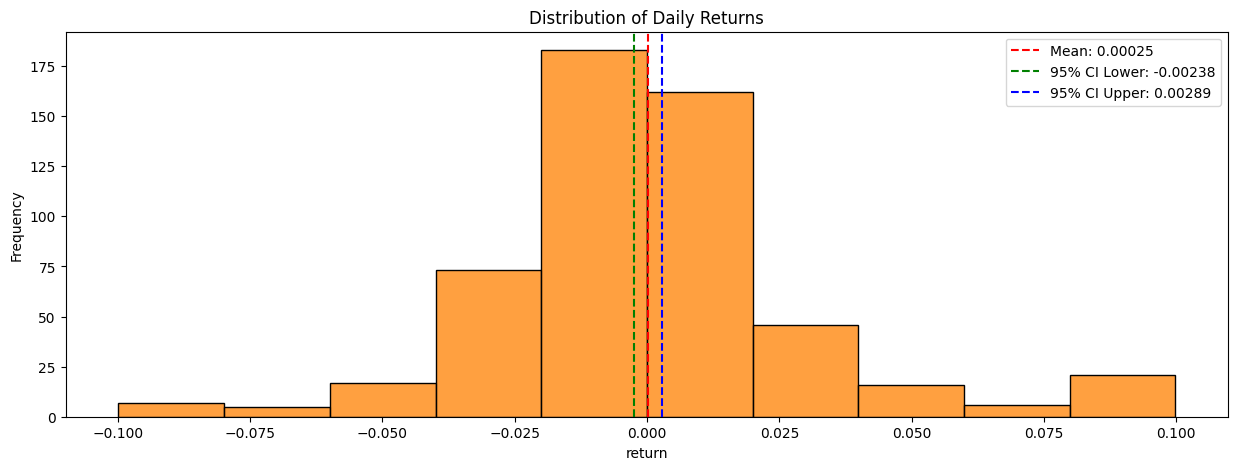

In [93]:
plt.figure(figsize=(15, 5))
sns.histplot(data = stock_df, x = 'return', color= '#FF8000', kde=False, bins=10)
plt.axvline(stock_df_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {round(stock_df_mean, 5)}')
plt.axvline(lower_bound, color='green', linestyle='dashed', linewidth=1.5, label=f'95% CI Lower: {round(lower_bound, 5)}')
plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=1.5, label=f'95% CI Upper: {round(upper_bound, 5)}')
plt.title('Distribution of Daily Returns')
plt.ylabel('Frequency')
plt.legend()


In [94]:
Bull_data.to_csv(f"{stock_no}_Bull_data.csv", index=False, encoding="utf-8")
Bear_data.to_csv(f"{stock_no}_Bear_data.csv", index=False, encoding="utf-8")

In [ ]:
# yfinance沒有夏都
# ticker = '2722.TW'

# shiadu = yf.download(ticker, start='2023-01-01', end='2025-03-31')

# print(shiadu.head())

Failed to get ticker '2722.TW' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['2722.TW']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Empty DataFrame
Columns: [(Adj Close, 2722.TW), (Close, 2722.TW), (High, 2722.TW), (Low, 2722.TW), (Open, 2722.TW), (Volume, 2722.TW)]
Index: []


In [127]:
news = pd.read_csv('bda2025_202301-202503_內容數據_新聞.csv')
dcard1 = pd.read_csv('bda2025_202301-202503_討論數據_dcard_1.csv')
dcard2 = pd.read_csv('bda2025_202301-202503_討論數據_dcard_2.csv')
mobile01 = pd.read_csv('bda2025_202301-202503_討論數據_Mobile01.csv')
ptt = pd.read_csv('bda2025_202301-202503_討論數據_PTT.csv')
df = pd.concat([news, dcard1, dcard2, mobile01, ptt],axis=0).reset_index(drop=True)
df.head(10)

,id,p_type,s_name,s_area_name,post_time,title,author,content,page_url,content_type
0,1672541649216_YahooNews,news,Yahoo新聞,股市匯市,2023-01-01 10:45:18,年關將近！準備換新鈔 央行「鈔前部署」3招辨真假,三立新聞網,記者戴玉翔／綜合報導新的一年即將到來，而在農曆年前，台灣人都有換新鈔的習慣，中央銀行預計會在...,https://tw.news.yahoo.com/%E5%B9%B4%E9%97%9C%E...,NaN
1,1672546740027_YahooNews,news,Yahoo新聞,股市匯市,2023-01-01 12:12:25,快加油！油價明調漲 汽油貴0.4元、柴油調降0.1元,王馨儀,台灣中油公司自明（2）日凌晨零時起汽油調漲0.4元、柴油調降0.1元，參考零售價格分別為92...,https://tw.news.yahoo.com/%E5%BF%AB%E5%8A%A0%E...,NaN
2,1672564766561_YahooNews,news,Yahoo新聞,股市匯市,2023-01-01 17:11:26,2023台股展望！農曆年還有紅包行情？,民視新聞網,民視新聞／綜合報導台北股市已經在2022年經歷過大熊市，那麼在即將到來的2023年，有沒有機...,https://tw.news.yahoo.com/2023%E5%8F%B0%E8%82%...,NaN
3,1672567021802_YahooNews,news,Yahoo新聞,股市匯市,2023-01-01 17:44:07,「反生命」喊話楊文科 要求終止生命園區開發,民視新聞網,民視新聞／ 綜合報導新竹縣的元旦升旗典禮，發生場外插曲，原來是新豐、湖口兩鄉居民，組成的反生...,https://tw.news.yahoo.com/%E5%8F%8D%E7%94%9F%E...,NaN
4,1672567849204_YahooNews,news,Yahoo新聞,股市匯市,2023-01-01 18:01:02,2023台股展望！農曆年還有紅包行情？,NaN,民視新聞／綜合報導台北股市已經在2022年經歷過大熊市，那麼在即將到來的2023年，有沒有機...,https://tw.news.yahoo.com/2023%E5%8F%B0%E8%82%...,NaN
5,1672612717793_YahooNews,news,Yahoo新聞,股市匯市,2023-01-02 06:25:41,2023年台幣有望反彈？ 分析師：重回29元字頭有難度,記者巫其倫／台北即時報導,台幣兌美元匯率去年重貶9.83%、創25年來最大跌幅，市場預期進入2023年美國升息放緩，市...,https://tw.news.yahoo.com/2023%E5%B9%B4%E5%8F%...,NaN
6,1672612717905_YahooNews,news,Yahoo新聞,股市匯市,2023-01-02 06:25:41,疫情紅利沒了！2022年金融業獲利恐跌破6000億探4年低,記者廖珮君／台北即時報導,2022年受升息、股債崩跌、防疫險理賠潮等三大利空罩頂，使金融業全年獲利恐跌破6000億元大...,https://tw.news.yahoo.com/%E7%96%AB%E6%83%85%E...,NaN
7,1672628233544_YahooNews,news,Yahoo新聞,股市匯市,2023-01-02 10:41:57,元旦假期收假 午後國5北向高乘載,記者鄭妤安／台北報導,[NOWnews今日新聞]今（2）日為元旦假期最後一天，交通部高速公路局研判，國道9路段易塞...,https://tw.news.yahoo.com/%E5%85%83%E6%97%A6%E...,NaN
8,1672641756629_YahooNews,news,Yahoo新聞,股市匯市,2023-01-02 14:28:13,台股1/3開紅盤 法人：留意新趨勢產業與解封需求,The Central News Agency 中央通訊社,（中央社記者吳家豪台北2日電）台股2023年將於3日開紅盤，國內投信指出，可逐步留意受惠於新...,https://tw.news.yahoo.com/%E5%8F%B0%E8%82%A11-...,NaN
9,1672643312601_YahooNews,news,Yahoo新聞,股市匯市,2023-01-02 14:47:14,謝金河曬陶朱隱園「18億夜景」！網羨：有錢人視角,民視新聞網,財經中心／李明融報導全台最貴豪宅陶朱隱園，已經到了最後收尾階段，財信傳媒董事長謝金河日前受邀...,https://tw.news.yahoo.com/%E8%AC%9D%E9%87%91%E...,NaN


In [128]:
df.shape

(661994, 10)

In [129]:
df_filtered = df[(df['title'].str.contains("夏都")) | (df['content'].str.contains("夏都"))]
df_filtered.head(10)

,id,p_type,s_name,s_area_name,post_time,title,author,content,page_url,content_type
398,1673924326710_YahooNews,news,Yahoo新聞,股市匯市,2023-01-17 10:05:44,虎年封關電子熄火 航運觀光撐場 價跌量縮14900點震盪整理,鉅亨網記者郭幸宜 台北,台股今 (17) 日進行虎年封關交易，大盤多空勢力在平盤附近拉扯，權王台積電 (2330-T...,https://tw.news.yahoo.com/%E8%99%8E%E5%B9%B4%E...,NaN
958,1675924003375_YahooNews,news,Yahoo新聞,股市匯市,2023-02-09 14:19:37,春天來了...王品、新天地營收年增兩位數 雄獅年增近6倍、現增申購抽中賺2.8萬,葉佳華,受惠政府解除組團禁令，加上春節十天連假效應，觀光需求活絡帶動旅行社1月營收增長。（攝影／葉佳...,https://tw.news.yahoo.com/%E6%98%A5%E5%A4%A9%E...,NaN
1122,1676442785533_YahooNews,news,Yahoo新聞,股市匯市,2023-02-15 13:41:10,〈台股盤後〉台積重挫 大跌221點收15432點 摜破10日線,鉅亨網記者沈筱禎 台北,股神巴菲特旗下投資公司波克夏重砍台積電 ADR，減持幅度高達 86%，台積電現貨今 (15)...,https://tw.news.yahoo.com/%E5%8F%B0%E8%82%A1%E...,NaN
1260,1676879134931_YahooNews,news,Yahoo新聞,股市匯市,2023-02-20 14:58:33,台股反彈站回15500點 投信連3買 三大法人賣超19.76億元,鉅亨網新聞中心,台股今 (20) 日開低走高，隨著電子權值股止跌回穩，金融股強勢走揚，加上觀光百貨、車電等中...,https://tw.news.yahoo.com/%E5%8F%B0%E8%82%A1%E...,NaN
1315,1677035900334_YahooNews,news,Yahoo新聞,股市匯市,2023-02-22 10:23:50,〈台股盤中〉普丁搗亂電金臉綠 大盤失守月線跌破15400點,鉅亨網記者郭幸宜 台北,美股四大指數重挫，台股今 (22) 日也跟著臉綠，權王台積電 (2330-TW) 帶頭領跌，...,https://tw.news.yahoo.com/%E5%8F%B0%E8%82%A1%E...,NaN
1324,1677045659659_YahooNews,news,Yahoo新聞,股市匯市,2023-02-22 13:10:07,〈焦點股〉觀光族群聯袂亮燈 漲停家數占大盤近4成,鉅亨網記者王莞甯 台北,隨著美債殖利率飆升，美股重挫，台股加權指數今 (22) 日大跌超過百點，尤其中高價電子股遭摜...,https://tw.news.yahoo.com/%E7%84%A6%E9%BB%9E%E...,NaN
1327,1677051627941_YahooNews,news,Yahoo新聞,股市匯市,2023-02-22 15:10:13,美股重挫、科技股領跌 台股早盤跌217點｜#鏡新聞,NaN,台股今天（22日）受到美股4大指數週二全面下挫影響，跟進走跌，早盤最低下探15345點、重跌...,https://tw.news.yahoo.com/%E7%BE%8E%E8%82%A1%E...,NaN
1360,1677121476845_YahooNews,news,Yahoo新聞,股市匯市,2023-02-23 10:55:23,台積電回穩運輸觀光強攻 台股盤中漲逾200點,The Central News Agency 中央通訊社,（中央社記者韓婷婷台北23日電）輝達（Nvidia）財報優於預期盤後大漲逾8%，帶動美股電子...,https://tw.news.yahoo.com/%E5%8F%B0%E7%A9%8D%E...,NaN
1361,1677121476696_YahooNews,news,Yahoo新聞,股市匯市,2023-02-23 10:59:09,台股盤中漲逾200點 台積電大漲14元,NaN,輝達（Nvidia）財報優於預期盤後大漲逾8%，帶動美股電子盤走揚，台股在台積電回穩反攻，搭...,https://tw.news.yahoo.com/%E5%8F%B0%E8%82%A1%E...,NaN
1542,1677722877669_YahooNews,news,Yahoo新聞,股市匯市,2023-03-02 09:19:18,盤中速報 - 觀光類指數類股表現強勁，漲幅3.9%，總成交額19.90億,鉅亨網新聞中心,台股今日觀光事業類股表現強勁，02日09:19相關指數上漲3.9%，總成交額19.90億元，...,https://tw.news.yahoo.com/%E7%9B%A4%E4%B8%AD%E...,NaN


In [130]:
df_filtered = df_filtered[['post_time','title', 'content']]
df_filtered.shape

(683, 3)

In [131]:
df_filtered['post_time'] = pd.to_datetime(df_filtered['post_time']).dt.date
df_filtered.head(10)


,post_time,title,content
398,2023-01-17,虎年封關電子熄火 航運觀光撐場 價跌量縮14900點震盪整理,台股今 (17) 日進行虎年封關交易，大盤多空勢力在平盤附近拉扯，權王台積電 (2330-T...
958,2023-02-09,春天來了...王品、新天地營收年增兩位數 雄獅年增近6倍、現增申購抽中賺2.8萬,受惠政府解除組團禁令，加上春節十天連假效應，觀光需求活絡帶動旅行社1月營收增長。（攝影／葉佳...
1122,2023-02-15,〈台股盤後〉台積重挫 大跌221點收15432點 摜破10日線,股神巴菲特旗下投資公司波克夏重砍台積電 ADR，減持幅度高達 86%，台積電現貨今 (15)...
1260,2023-02-20,台股反彈站回15500點 投信連3買 三大法人賣超19.76億元,台股今 (20) 日開低走高，隨著電子權值股止跌回穩，金融股強勢走揚，加上觀光百貨、車電等中...
1315,2023-02-22,〈台股盤中〉普丁搗亂電金臉綠 大盤失守月線跌破15400點,美股四大指數重挫，台股今 (22) 日也跟著臉綠，權王台積電 (2330-TW) 帶頭領跌，...
1324,2023-02-22,〈焦點股〉觀光族群聯袂亮燈 漲停家數占大盤近4成,隨著美債殖利率飆升，美股重挫，台股加權指數今 (22) 日大跌超過百點，尤其中高價電子股遭摜...
1327,2023-02-22,美股重挫、科技股領跌 台股早盤跌217點｜#鏡新聞,台股今天（22日）受到美股4大指數週二全面下挫影響，跟進走跌，早盤最低下探15345點、重跌...
1360,2023-02-23,台積電回穩運輸觀光強攻 台股盤中漲逾200點,（中央社記者韓婷婷台北23日電）輝達（Nvidia）財報優於預期盤後大漲逾8%，帶動美股電子...
1361,2023-02-23,台股盤中漲逾200點 台積電大漲14元,輝達（Nvidia）財報優於預期盤後大漲逾8%，帶動美股電子盤走揚，台股在台積電回穩反攻，搭...
1542,2023-03-02,盤中速報 - 觀光類指數類股表現強勁，漲幅3.9%，總成交額19.90億,台股今日觀光事業類股表現強勁，02日09:19相關指數上漲3.9%，總成交額19.90億元，...


In [132]:
df_filtered

,post_time,title,content
398,2023-01-17,虎年封關電子熄火 航運觀光撐場 價跌量縮14900點震盪整理,台股今 (17) 日進行虎年封關交易，大盤多空勢力在平盤附近拉扯，權王台積電 (2330-T...
958,2023-02-09,春天來了...王品、新天地營收年增兩位數 雄獅年增近6倍、現增申購抽中賺2.8萬,受惠政府解除組團禁令，加上春節十天連假效應，觀光需求活絡帶動旅行社1月營收增長。（攝影／葉佳...
1122,2023-02-15,〈台股盤後〉台積重挫 大跌221點收15432點 摜破10日線,股神巴菲特旗下投資公司波克夏重砍台積電 ADR，減持幅度高達 86%，台積電現貨今 (15)...
1260,2023-02-20,台股反彈站回15500點 投信連3買 三大法人賣超19.76億元,台股今 (20) 日開低走高，隨著電子權值股止跌回穩，金融股強勢走揚，加上觀光百貨、車電等中...
1315,2023-02-22,〈台股盤中〉普丁搗亂電金臉綠 大盤失守月線跌破15400點,美股四大指數重挫，台股今 (22) 日也跟著臉綠，權王台積電 (2330-TW) 帶頭領跌，...
...,...,...,...
654027,2024-11-20,[創作] Baby Shark(夏都),https://youtu.be/XqZsoesa55w 突然有一咪咪靈感(? ====...
657595,2025-01-09,[新聞] 慘！墾丁驚傳3家飯店將熄燈 觀光業再受,原文標題： 慘！墾丁驚傳3家飯店將熄燈 觀光業再受重擊 原文連結： https://n...
658099,2025-01-14,[情報] 2722 夏都12月自結,標題： 2722 夏都12月自結 來源： 公開資訊觀測站 網址： https://...
658359,2025-01-17,[閒聊] 2025/01/17 盤後閒聊,台 股 23148.08 ▲122.98 (+0.53%) 3203.17億 台指02 23...


In [133]:
df_filtered.to_csv(f"{stock_no}_news.csv", index=False, encoding="utf-8")

In [134]:
import csv
import monpa
from monpa import utils

In [135]:
#篩選出顯示牛市或熊市的新聞
df_filtered['post_time'] = pd.to_datetime(df_filtered['post_time']).dt.date
Bull_data['previous_date_2'] = pd.to_datetime(Bull_data['previous_date_2']).dt.date
Bear_data['previous_date_2'] = pd.to_datetime(Bear_data['previous_date_2']).dt.date


Bull_news = df_filtered[df_filtered['post_time'].isin(Bull_data['previous_date_2'])]
Bear_news = df_filtered[df_filtered['post_time'].isin(Bear_data['previous_date_2'])]
Bull_news['BullBear'] = 1
Bear_news['BullBear'] = -1
Bull_news

/var/folders/dp/v8nwqctd0rqfmk1cclf4q0w40000gn/T/ipykernel_19173/2288370449.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bull_news['BullBear'] = 1
/var/folders/dp/v8nwqctd0rqfmk1cclf4q0w40000gn/T/ipykernel_19173/2288370449.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bear_news['BullBear'] = -1


,post_time,title,content,BullBear
1122,2023-02-15,〈台股盤後〉台積重挫 大跌221點收15432點 摜破10日線,股神巴菲特旗下投資公司波克夏重砍台積電 ADR，減持幅度高達 86%，台積電現貨今 (15)...,1
1315,2023-02-22,〈台股盤中〉普丁搗亂電金臉綠 大盤失守月線跌破15400點,美股四大指數重挫，台股今 (22) 日也跟著臉綠，權王台積電 (2330-TW) 帶頭領跌，...,1
1324,2023-02-22,〈焦點股〉觀光族群聯袂亮燈 漲停家數占大盤近4成,隨著美債殖利率飆升，美股重挫，台股加權指數今 (22) 日大跌超過百點，尤其中高價電子股遭摜...,1
1327,2023-02-22,美股重挫、科技股領跌 台股早盤跌217點｜#鏡新聞,台股今天（22日）受到美股4大指數週二全面下挫影響，跟進走跌，早盤最低下探15345點、重跌...,1
1360,2023-02-23,台積電回穩運輸觀光強攻 台股盤中漲逾200點,（中央社記者韓婷婷台北23日電）輝達（Nvidia）財報優於預期盤後大漲逾8%，帶動美股電子...,1
...,...,...,...,...
615959,2023-07-24,[情報] 00733成分股審核結果,1. 標題：「臺灣指數公司中小型 A 級動能 50 指數」第三次成分股審核結果 2. 來源...,1
632288,2024-03-31,[心得] 2024年Q1 台股跌幅排行榜,代號 公司 市場 跌幅(%) 23Q4 24Q1 ...,1
637283,2024-05-28,[新聞] 5月底將公布兩岸旅遊開放利多 觀光股先買,原文標題： 5月底將公布兩岸旅遊開放利多 觀光股先買先贏「這六檔」率先漲停 原文連結：h...,1
642871,2024-07-22,[情報] 2722 夏都 辦理現金增資 暫定價35元,1. 標題：公告本公司董事會通過辦理現金增資發行普通股 2. 來源：公開資訊觀測站 3....,1


In [136]:
Bear_news

,post_time,title,content,BullBear
958,2023-02-09,春天來了...王品、新天地營收年增兩位數 雄獅年增近6倍、現增申購抽中賺2.8萬,受惠政府解除組團禁令，加上春節十天連假效應，觀光需求活絡帶動旅行社1月營收增長。（攝影／葉佳...,-1
1260,2023-02-20,台股反彈站回15500點 投信連3買 三大法人賣超19.76億元,台股今 (20) 日開低走高，隨著電子權值股止跌回穩，金融股強勢走揚，加上觀光百貨、車電等中...,-1
1697,2023-03-07,電金傳點火！台股成功站15800點,[NOWnews今日新聞]全球市場等待美國聯準會（Fed）主席鮑爾發表談話以及就業數據發布，...,-1
1924,2023-03-14,資金提款走人 電金傳氣虛 台股大跌逾170點,矽谷銀行 (SVB) 倒閉觸發市場恐慌情緒，美股僅那指上漲，其餘三大指數全數下跌，台股今 (...,-1
2471,2023-03-29,〈台股盤中〉漲幅收斂收斂 觀光族群、散熱雙雄逆勢強漲,儘管美股四大指數 28 日收跌，台股今 (29) 日經歷連兩日跌勢後反彈走強，早盤權值股紛紛...,-1
...,...,...,...,...
646205,2024-08-19,[新聞] 10大旅館營收「亮紅字」衰退16% 學者：,原文標題：10大旅館營收「亮紅字」衰退16% 學者：年底恐有倒閉潮 原文連結：https...,-1
646232,2024-08-19,[新聞] 台人更愛出國！花蓮知名飯店「營收跳水72,作者: buzu () 看板: Gossiping 標題: [新聞] 台人更愛出國！花蓮知...,-1
648536,2024-09-12,[新聞] 【退休只買一支股1】交給股神巴菲特操盤,原文標題： 【退休只買一支股1】交給股神巴菲特操盤 國小老師靠1檔股票輕鬆退休 原文連結...,-1
652876,2024-11-07,[情報] 2722 夏都 申購抽籤日程資訊,1. 標題：2722 夏都 申購抽籤日程資訊 2. 來源：TWSE 公開申購公告-抽籤日程...,-1


In [137]:
print(Bull_news.shape)
print(Bear_news.shape)

(269, 4)
(220, 4)


In [138]:
Bull_news.to_csv(f"{stock_no}_Bull_news.csv", index=False, encoding="utf-8")
Bear_news.to_csv(f"{stock_no}_Bear_news.csv", index=False, encoding="utf-8")